# The notebook explore finetuned OpenAI model for price prediction

In [15]:
import sys
import os
# Add the project root to sys.path
project_root = os.path.abspath("..")  # Move one level up to the project root
if project_root not in sys.path:
    sys.path.insert(0, project_root)# change working directory to project root
import os
import re
import math
import json
import random
import pickle
import numpy as np
import pandas as pd
from utils.items import Item
from utils.tester import Tester
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from huggingface_hub import login
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

%matplotlib inline


In [2]:
openai_llm = ChatOpenAI(model="gpt-4o-mini")
anthropic_llm = ChatAnthropic(model="claude-3-sonnet-20240229")
HF_TOKEN = os.getenv('HUGGINGFACE_TOKEN')

In [3]:
# Load data
## Add an alias in sys.modules
# os.chdir("..")
sys.modules['items'] = sys.modules['utils.items']

with open('data/train.pkl', 'rb') as f:
    train = pickle.load(f, encoding='latin1')

with open('data/test.pkl', 'rb') as f:
    test = pickle.load(f)

In [32]:
# OpenAI recommends fine-tuning with populations of 50-100 examples

fine_tune_train = train[:500]
fine_tune_validation = train[500:550]

## 1.0. Preparing the dataset

Prepare the data in the format of jsonl (json lines) format and upload to OpenAI.

In [21]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [22]:
messages_for(fine_tune_train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nAT-A-GLANCE Daily Appointment Book 2015, 4.88 x 8 Inch Page Size, Black\nAround-the-clock planning, 24 hours a day, 7 days a week for the full year. Includes military and standard times with one day per page and hourly appointments, 12 p.m., including weekends. 12 months of planning power, January–December; 4.88 x 8 inch page size; 5.81 x 8.31 x.38 inches overall; Julian dates. One day per page; notes space; past, current and two future months reference. Printed on quality recycled paper with 30% post-consumer waste; black simulated leather wirebound cover. Made in the U.S.A. Get around-the-clock planning with this'},
 {'role': 'assistant', 'content': 'Price is $30.86'}]

In [23]:
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [24]:
print(make_jsonl(fine_tune_train[:2]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nAT-A-GLANCE Daily Appointment Book 2015, 4.88 x 8 Inch Page Size, Black\nAround-the-clock planning, 24 hours a day, 7 days a week for the full year. Includes military and standard times with one day per page and hourly appointments, 12 p.m., including weekends. 12 months of planning power, January\u2013December; 4.88 x 8 inch page size; 5.81 x 8.31 x.38 inches overall; Julian dates. One day per page; notes space; past, current and two future months reference. Printed on quality recycled paper with 30% post-consumer waste; black simulated leather wirebound cover. Made in the U.S.A. Get around-the-clock planning with this"}, {"role": "assistant", "content": "Price is $30.86"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "

In [25]:
# Function to convert the items into jsonl and write them into a file
def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [33]:
# Write the jsonl files in `data` folder
write_jsonl(fine_tune_train, 'data/fine_tune_train.jsonl')
write_jsonl(fine_tune_validation, 'data/fine_tune_validation.jsonl')


In [58]:
from openai import OpenAI

openai = OpenAI()

with open("data/fine_tune_train.jsonl", 'rb') as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [59]:
with open("data/fine_tune_validation.jsonl", 'rb') as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [60]:
train_file, validation_file

(FileObject(id='file-GsMQ7YhfQpJzcXgtqtA8eNKp', bytes=473632, created_at=1729703261, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None),
 FileObject(id='file-trzOCjCl596aCceI4kJsk0zR', bytes=46359, created_at=1729703262, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None))

## 2.0. Start finefuning

In [61]:
# Use Weights&Bias to keep track of the finetuning
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [67]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model='gpt-4o-mini-2024-07-18',
    seed=42,
    hyperparameters={"n_epochs":1},
    integrations = [wandb_integration],
    suffix="gpt-pricer"
)

FineTuningJob(id='ftjob-mPL9zZ2ipZuOyEeYClM0aUJz', created_at=1729703328, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-QwkaiIVYTMEnksnVSLDagho7', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-GsMQ7YhfQpJzcXgtqtA8eNKp', validation_file='file-trzOCjCl596aCceI4kJsk0zR', estimated_finish=None, integrations=[], user_provided_suffix='gpt-pricer')

In [68]:
openai.fine_tuning.jobs.list()

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-mPL9zZ2ipZuOyEeYClM0aUJz', created_at=1729703328, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-QwkaiIVYTMEnksnVSLDagho7', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-GsMQ7YhfQpJzcXgtqtA8eNKp', validation_file='file-trzOCjCl596aCceI4kJsk0zR', estimated_finish=None, integrations=[], user_provided_suffix='gpt-pricer')], object='list', has_more=False)

In [69]:
job_id = openai.fine_tuning.jobs.list().data[0].id

In [71]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-mPL9zZ2ipZuOyEeYClM0aUJz', created_at=1729703328, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-QwkaiIVYTMEnksnVSLDagho7', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-GsMQ7YhfQpJzcXgtqtA8eNKp', validation_file='file-trzOCjCl596aCceI4kJsk0zR', estimated_finish=None, integrations=[], user_provided_suffix='gpt-pricer')

In [81]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-vtXhVXL7hUnPV9TxXpqPiiOH', created_at=1729704186, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-JhxxBRZWHE1x9jEv4B66jaLx', created_at=1729704181, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-0c756bJYRGZApAs7gwECouVo', created_at=1729704161, level='info', message='Step 500/500: training loss=1.43, validation loss=1.40, full validation loss=1.03', object='fine_tuning.job.event', data={'step': 500, 'train_loss': 1.4301223754882812, 'valid_loss': 1.3987600803375244, 'total_steps': 500, 'full_valid_loss': 1.032523102760315, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.795}, type='metrics'),
 FineTuningJobEvent(id='ftevent-uNWPbvqEDMoRYcBVKMq7iYot', created_at=1729704122, level='info', message='Step 4

## 3.0. Evaluate the fine-fined model

In [82]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [83]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:hiredly:gpt-pricer:ALZMTqIm'

In [85]:
openai_llm = ChatOpenAI(model=fine_tuned_model_name)

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

def messages_for(item):
    system_message = "You estimate prices of items. reply only with the price, no explaination."
    user_prompt = item.test_prompt().replace(" to the nearest dollor", "").replace("\n\nPrice is $", "")
    return [
        SystemMessage(content=system_message),
         HumanMessage(content=user_prompt),
         AIMessage(content="Price is $")
    ]
    
    # A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

def openai_get_price(item) :
    response = openai_llm.invoke(messages_for(item), max_tokens=5, seed=42).content
    # Extract the price from the response
    return get_price(response)

openai_get_price(test[0])

39.0

1: Guess: $39.00 | Truth: $97.99 | Error: $58.99 | SLE: $0.82 | Item: Aukilus LCD Display Touch Screen Digitiz...
2: Guess: $103.00 | Truth: $116.92 | Error: $13.92 | SLE: $0.02 | Item: Depo 312-19C6R-AF Replacement Auto Part ...
3: Guess: $285.00 | Truth: $410.00 | Error: $125.00 | SLE: $0.13 | Item: Digital Check CheXpress Scanner WITHOUT ...
4: Guess: $161.00 | Truth: $68.76 | Error: $92.24 | SLE: $0.71 | Item: Greenwald Industries 8-1170 Genuine OEM ...
5: Guess: $127.00 | Truth: $298.59 | Error: $171.59 | SLE: $0.72 | Item: Innovative Mounts 90750-85A Black Bushin...
6: Guess: $161.00 | Truth: $228.99 | Error: $67.99 | SLE: $0.12 | Item: A-Premium Hydro-Boost Power Brake Booste...
7: Guess: $289.00 | Truth: $409.95 | Error: $120.95 | SLE: $0.12 | Item: B&M 70418 Tork Master 2400 Torque Conver...
8: Guess: $143.00 | Truth: $118.99 | Error: $24.01 | SLE: $0.03 | Item: Boxes Fast BFMFL1294K Deluxe Literature ...
9: Guess: $22.00 | Truth: $34.99 | Error: $12.99 | SLE: $0.20 | Item: 72

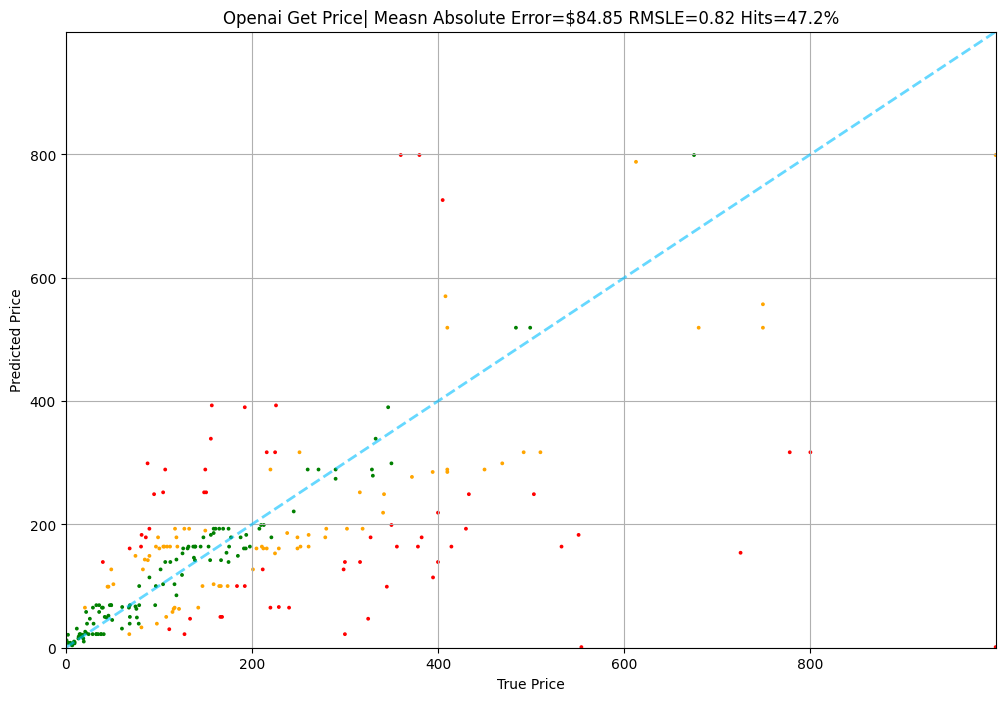

In [86]:
Tester.test(openai_get_price, test)